# === Personal Project ===
# eBay IPhone 14 Prices Prediction
This is a project for my Data Science Portofolio, currently ongoing.

Date: 11.27.2023

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import plotly.express as px

In [2]:
# Set up pandas
pd.set_option('display.max_colwidth', None)
# pd.set_option('display.max_rows', None)

# 1. Load Dataframe
-> iPhone 14 Pro Max Prices

In [3]:
df = pd.read_csv('data/ebay_iphone_14_pro_max.csv')

## 2. Data Preprocessing

In [4]:
# Make title all lowercase

df['Title'] = df['Title'].apply(lambda x: x.lower())

# remove all space
df['Title'] = df['Title'].str.replace('[^\w\s]', '', regex=True)

In [5]:
df

,Title,Price
0,apple iphone 14 pro max 512gb unlocked att tmobile verizon very good condition,$884.95
1,case for iphone 15 pro max 14 plus 13 12 11 xs shockproof full protective cover,$2.48 to $6.22
2,apple iphone 14 pro max a16 128gb 256gb 512gb 1tb unlocked new sealed,"$1,429.49 to $2,089.49"
3,apple iphone 14 pro max 256gb unlocked us e sim excellent,$909.99
4,apple iphone 14 pro max 128gb deep purple unlocked smartphone,$810.00
...,...,...
1018,apple iphone 14 pro max 256gb space black unlocked a2651 gsm,$940.00
1019,apple iphone 14 pro max 128gb gold verizon,$950.00
1020,iphone 14 pro max 128gb silver unlocked,"$1,008.98"
1021,apple iphone 14 pro max 1tb deep purple tmobile,"$1,300.00"


## 2 Data Cleaning & Feature Engineering

### 2 Feature Engineering

what affects the prices of the iPhone?
Based on the Title Column of df.
1. Condition:
    Damaged = 3, 
    Good = 2, 
    Very Good / Excellent = 1, 
    Brand New = 0
    
2. Storage: 1TB = 0, 512GB = 1, 256GB = 2, 128GB = 3
3. IMEI: if has check imei, prices may be less (needs to be compared)
4. ESN: if has check ESN or bad ESN, prices may be less
3. Color (?)
4. Unlocked -> A factory unlock for your iPhone lets you swap out your current service carrier for a new carrier or several.
    Unlocked tends to be more expensive.
    1 unlock, 0 lock
    
Goals: Make new Column based on the categories that affected the prices.

In [6]:
# Source: Apple

iphone_colors = ["gold", "silver", "deep purple", "space black", "black", "purple"]
# space black and deep purple simplified to deep purple and space black

In [7]:
# extract storage capacity function
def extract_storage_capacity(title):
    # match = re.search(r'\b(\d+GB)\b', title, re.IGNORECASE)
    match = re.search(r'\b(\d+\s?(gb|tb))\b', title, re.IGNORECASE)
    return match.group(1).replace('gb', '').replace('tb', '000').replace(' tb','000') if match else None

# extract color function
def extract_color(title):
    for color in iphone_colors:
        if color in title.lower():
            return color.capitalize()
    return None

# Helper function to extract condition
def extract_condition(title):
    conditions = ["new", "used", "refurbished", 'very good', 'excellent', 'fair', 'damaged', 'cracked', 'broken']
    for condition in conditions:
        if condition in title.lower():
            return condition.capitalize()
    return "Unknown"

# Extracting new features
df['Storage Capacity'] = df['Title'].apply(extract_storage_capacity)
df['Color'] = df['Title'].apply(extract_color)
df['Condition'] = df['Title'].apply(extract_condition)

# Displaying the updated dataframe
df.head()

,Title,Price,Storage Capacity,Color,Condition
0,apple iphone 14 pro max 512gb unlocked att tmobile verizon very good condition,$884.95,512,None,Very good
1,case for iphone 15 pro max 14 plus 13 12 11 xs shockproof full protective cover,$2.48 to $6.22,None,None,Unknown
2,apple iphone 14 pro max a16 128gb 256gb 512gb 1tb unlocked new sealed,"$1,429.49 to $2,089.49",128,None,New
3,apple iphone 14 pro max 256gb unlocked us e sim excellent,$909.99,256,None,Excellent
4,apple iphone 14 pro max 128gb deep purple unlocked smartphone,$810.00,128,Deep purple,Unknown


### Colour Column

In [8]:
# df = df.drop(df.loc[~df['Color'].isin()])

# map colors as a digit

color_mapping = {
    None: 0, "gold": 1, "silver": 2, "purple": 3, "deep purple": 3, "black": 4, "space black": 4
}

df['color_number'] = df['Color'].str.lower().map(color_mapping)

In [9]:
df

,Title,Price,Storage Capacity,Color,Condition,color_number
0,apple iphone 14 pro max 512gb unlocked att tmobile verizon very good condition,$884.95,512,None,Very good,0
1,case for iphone 15 pro max 14 plus 13 12 11 xs shockproof full protective cover,$2.48 to $6.22,None,None,Unknown,0
2,apple iphone 14 pro max a16 128gb 256gb 512gb 1tb unlocked new sealed,"$1,429.49 to $2,089.49",128,None,New,0
3,apple iphone 14 pro max 256gb unlocked us e sim excellent,$909.99,256,None,Excellent,0
4,apple iphone 14 pro max 128gb deep purple unlocked smartphone,$810.00,128,Deep purple,Unknown,3
...,...,...,...,...,...,...
1018,apple iphone 14 pro max 256gb space black unlocked a2651 gsm,$940.00,256,Space black,Unknown,4
1019,apple iphone 14 pro max 128gb gold verizon,$950.00,128,Gold,Unknown,1
1020,iphone 14 pro max 128gb silver unlocked,"$1,008.98",128,Silver,Unknown,2
1021,apple iphone 14 pro max 1tb deep purple tmobile,"$1,300.00",1000,Deep purple,Unknown,3


### Condition Columns

In [10]:
# Grab all unique values in condition
values = df['Condition'].unique()
values

array(['Very good', 'Unknown', 'New', 'Excellent', 'Fair', 'Damaged',
       'Broken', 'Cracked', 'Used', 'Refurbished'], dtype=object)

In [11]:
# Categorize each condition to generalize it. Here I selected 4 conditions

condition_numeric_mapping = {
    'Very good': 3, 'Excellent': 3, 'New': 3,  # Good condition
    'Fair': 2, 'Used': 2, 'Refurbished': 2,    # Ok condition
    'Damaged': 1, 'Cracked': 1, 'Broken': 1,   # Bad condition
    'Unknown': 0                               # Unknown condition
}

# Applying the numeric mapping to the 'Condition' column
df['Condition_number'] = df['Condition'].map(condition_numeric_mapping)

In [12]:
df.head()

,Title,Price,Storage Capacity,Color,Condition,color_number,Condition_number
0,apple iphone 14 pro max 512gb unlocked att tmobile verizon very good condition,$884.95,512,None,Very good,0,3
1,case for iphone 15 pro max 14 plus 13 12 11 xs shockproof full protective cover,$2.48 to $6.22,None,None,Unknown,0,0
2,apple iphone 14 pro max a16 128gb 256gb 512gb 1tb unlocked new sealed,"$1,429.49 to $2,089.49",128,None,New,0,3
3,apple iphone 14 pro max 256gb unlocked us e sim excellent,$909.99,256,None,Excellent,0,3
4,apple iphone 14 pro max 128gb deep purple unlocked smartphone,$810.00,128,Deep purple,Unknown,3,0


In [13]:
df

,Title,Price,Storage Capacity,Color,Condition,color_number,Condition_number
0,apple iphone 14 pro max 512gb unlocked att tmobile verizon very good condition,$884.95,512,None,Very good,0,3
1,case for iphone 15 pro max 14 plus 13 12 11 xs shockproof full protective cover,$2.48 to $6.22,None,None,Unknown,0,0
2,apple iphone 14 pro max a16 128gb 256gb 512gb 1tb unlocked new sealed,"$1,429.49 to $2,089.49",128,None,New,0,3
3,apple iphone 14 pro max 256gb unlocked us e sim excellent,$909.99,256,None,Excellent,0,3
4,apple iphone 14 pro max 128gb deep purple unlocked smartphone,$810.00,128,Deep purple,Unknown,3,0
...,...,...,...,...,...,...,...
1018,apple iphone 14 pro max 256gb space black unlocked a2651 gsm,$940.00,256,Space black,Unknown,4,0
1019,apple iphone 14 pro max 128gb gold verizon,$950.00,128,Gold,Unknown,1,0
1020,iphone 14 pro max 128gb silver unlocked,"$1,008.98",128,Silver,Unknown,2,0
1021,apple iphone 14 pro max 1tb deep purple tmobile,"$1,300.00",1000,Deep purple,Unknown,3,0


### Network Carrier

In [14]:
# Analyze unique samples of title

unique_titles_sample = df['Title'].dropna().unique()[:50]  # Analyzing first 50 unique titles

unique_titles_sample

array(['apple iphone 14 pro max 512gb unlocked att tmobile verizon very good condition',
       'case for iphone 15 pro max 14 plus 13 12 11 xs shockproof full protective cover',
       'apple iphone 14 pro max a16 128gb 256gb 512gb 1tb unlocked new sealed',
       'apple iphone 14 pro max 256gb  unlocked us e sim  excellent',
       'apple iphone 14 pro max  128gb  deep purple unlocked smartphone',
       'new listingapple iphone 14 pro max  128gb black unlocked',
       'apple iphone 14 pro max 256gb  unlocked us e sim  very good',
       'apple iphone 14 pro max space black  for parts only not working lcd issue',
       'apple iphone 14 pro max 256gb space black unlocked fair condition',
       'new listingapple iphone 14 pro max 256gb  purple  blocked opened never used',
       'new listingapple iphone 14 pro max  256gb  space black carrier locked  check esn',
       'tmobile apple iphone 14 pro max 256gb mq8w3lla a2651 no reserve',
       'new listingapple iphone 14 pro max  128gb

In [15]:
# func to extract network carrier

def extract_network_carrier_enhanced(title):
    # Expanded list of carriers with common variations
    carriers = [
        "unlocked", "att", "tmobile", "verizon", "sprint", "us cellular", 
        "cricket", "metro", "boost mobile", "virgin mobile", "straight talk", 
        "tracfone", "google fi", "xfinity mobile", "vodafone", "o2", "ee", "three"
    ]
    for carrier in carriers:
        if re.search(r'\b' + re.escape(carrier) + r'\b', title, re.IGNORECASE):
            return carrier
    return "other/unknown"  # Default category for titles where no carrier is detected

df['Network Carrier'] = df['Title'].apply(extract_network_carrier_enhanced)

In [16]:
df

,Title,Price,Storage Capacity,Color,Condition,color_number,Condition_number,Network Carrier
0,apple iphone 14 pro max 512gb unlocked att tmobile verizon very good condition,$884.95,512,None,Very good,0,3,unlocked
1,case for iphone 15 pro max 14 plus 13 12 11 xs shockproof full protective cover,$2.48 to $6.22,None,None,Unknown,0,0,other/unknown
2,apple iphone 14 pro max a16 128gb 256gb 512gb 1tb unlocked new sealed,"$1,429.49 to $2,089.49",128,None,New,0,3,unlocked
3,apple iphone 14 pro max 256gb unlocked us e sim excellent,$909.99,256,None,Excellent,0,3,unlocked
4,apple iphone 14 pro max 128gb deep purple unlocked smartphone,$810.00,128,Deep purple,Unknown,3,0,unlocked
...,...,...,...,...,...,...,...,...
1018,apple iphone 14 pro max 256gb space black unlocked a2651 gsm,$940.00,256,Space black,Unknown,4,0,unlocked
1019,apple iphone 14 pro max 128gb gold verizon,$950.00,128,Gold,Unknown,1,0,verizon
1020,iphone 14 pro max 128gb silver unlocked,"$1,008.98",128,Silver,Unknown,2,0,unlocked
1021,apple iphone 14 pro max 1tb deep purple tmobile,"$1,300.00",1000,Deep purple,Unknown,3,0,tmobile


In [17]:
df['Network Carrier'].value_counts()

Network Carrier
unlocked          488
other/unknown     253
att               111
verizon            86
tmobile            66
us cellular         5
cricket             3
straight talk       3
vodafone            2
xfinity mobile      2
sprint              2
o2                  1
ee                  1
Name: count, dtype: int64

In [18]:
df.loc[df['Network Carrier'] == 'other/unknown']

,Title,Price,Storage Capacity,Color,Condition,color_number,Condition_number,Network Carrier
1,case for iphone 15 pro max 14 plus 13 12 11 xs shockproof full protective cover,$2.48 to $6.22,None,None,Unknown,0,0,other/unknown
7,apple iphone 14 pro max space black for parts only not working lcd issue,$325.00,None,Space black,Unknown,4,0,other/unknown
9,new listingapple iphone 14 pro max 256gb purple blocked opened never used,$123.32,256,Purple,New,3,3,other/unknown
10,new listingapple iphone 14 pro max 256gb space black carrier locked check esn,$530.00,256,Space black,New,4,3,other/unknown
15,apple iphone 14 pro max 128gb space blackus cellular look at lens read,$495.00,128,Space black,Unknown,4,0,other/unknown
...,...,...,...,...,...,...,...,...
1001,case iphone 14 pro max,$12.90,None,None,Unknown,0,0,other/unknown
1003,apple iphone 14 pro max 512gb space black,"$1,887.76",512,Space black,Unknown,4,0,other/unknown
1007,apple iphone 14 pro max 1tb deep purple,"$2,159.86",1000,Deep purple,Unknown,3,0,other/unknown
1010,apple iphone 14 pro max a2651 made for tmobilesprint all colorsgb a grade,$829.99,None,None,Unknown,0,0,other/unknown


In [19]:
# Categorize the network carrier, such that:
# 0: Unlocked, 1: Locked to a specific carrier/Locked, 2: Other/Unknown

def categorize_carriers(carrier):
    if carrier == "unlocked":
        return 0  # Unlocked
    elif carrier == "other/unknown":
        return 2  # Other/Unknown
    else:
        return 1  # Locked to a specific carrier

# Applying the categorization function to the 'Network Carrier' column
df['Carrier Category'] = df['Network Carrier'].apply(categorize_carriers)

# Displaying the updated dataframe
df[['Title', 'Network Carrier', 'Carrier Category']].head()

,Title,Network Carrier,Carrier Category
0,apple iphone 14 pro max 512gb unlocked att tmobile verizon very good condition,unlocked,0
1,case for iphone 15 pro max 14 plus 13 12 11 xs shockproof full protective cover,other/unknown,2
2,apple iphone 14 pro max a16 128gb 256gb 512gb 1tb unlocked new sealed,unlocked,0
3,apple iphone 14 pro max 256gb unlocked us e sim excellent,unlocked,0
4,apple iphone 14 pro max 128gb deep purple unlocked smartphone,unlocked,0


In [20]:
df

,Title,Price,Storage Capacity,Color,Condition,color_number,Condition_number,Network Carrier,Carrier Category
0,apple iphone 14 pro max 512gb unlocked att tmobile verizon very good condition,$884.95,512,None,Very good,0,3,unlocked,0
1,case for iphone 15 pro max 14 plus 13 12 11 xs shockproof full protective cover,$2.48 to $6.22,None,None,Unknown,0,0,other/unknown,2
2,apple iphone 14 pro max a16 128gb 256gb 512gb 1tb unlocked new sealed,"$1,429.49 to $2,089.49",128,None,New,0,3,unlocked,0
3,apple iphone 14 pro max 256gb unlocked us e sim excellent,$909.99,256,None,Excellent,0,3,unlocked,0
4,apple iphone 14 pro max 128gb deep purple unlocked smartphone,$810.00,128,Deep purple,Unknown,3,0,unlocked,0
...,...,...,...,...,...,...,...,...,...
1018,apple iphone 14 pro max 256gb space black unlocked a2651 gsm,$940.00,256,Space black,Unknown,4,0,unlocked,0
1019,apple iphone 14 pro max 128gb gold verizon,$950.00,128,Gold,Unknown,1,0,verizon,1
1020,iphone 14 pro max 128gb silver unlocked,"$1,008.98",128,Silver,Unknown,2,0,unlocked,0
1021,apple iphone 14 pro max 1tb deep purple tmobile,"$1,300.00",1000,Deep purple,Unknown,3,0,tmobile,1


In [21]:
df.isna().sum()

Title                 0
Price                 0
Storage Capacity     92
Color               186
Condition             0
color_number          0
Condition_number      0
Network Carrier       0
Carrier Category      0
dtype: int64

### Storage Column

In [22]:
df.loc[df['Storage Capacity'].isna()].head(10)

,Title,Price,Storage Capacity,Color,Condition,color_number,Condition_number,Network Carrier,Carrier Category
1,case for iphone 15 pro max 14 plus 13 12 11 xs shockproof full protective cover,$2.48 to $6.22,None,None,Unknown,0,0,other/unknown,2
7,apple iphone 14 pro max space black for parts only not working lcd issue,$325.00,None,Space black,Unknown,4,0,other/unknown,2
19,apple iphone 14 pro or pro max parts and repairs only,$123.50,None,None,Unknown,0,0,other/unknown,2
27,case for iphone 15 14 13 12 11 xr 7 8 clear shockproof silicone 360 phone cover,$7.46,None,None,Unknown,0,0,other/unknown,2
29,case for iphone 14 13 12 11 xr 7 8 se 2 3 clear shockproof back 360 phone cover,$4.97 to $7.46,None,None,Unknown,0,0,other/unknown,2
30,360 full body case for iphone 14 13 12 11 pro max mini xr xs max 7 8 plus se,$6.22 to $7.46,None,None,Unknown,0,0,other/unknown,2
34,verizon apple iphone 14 pro max a2651 silver broken parts only read description,$435.00,None,Silver,Broken,2,1,verizon,1
46,case for iphone 14 12 13 pro max 11 7 8 360 clear shockproof silicone cover,$7.46,None,None,Unknown,0,0,other/unknown,2
56,case for iphone 15 14 13 12 11 xr 7 8 se 2 3 clear shockproof full phone cover,$7.46,None,None,Unknown,0,0,other/unknown,2
57,shockproof case for iphone 14 13 12 11 xr 7 8 se 2 clear full phone cover 360,$4.97 to $7.46,None,None,Unknown,0,0,other/unknown,2


In [23]:
# Drop all without storage capacity
df = df.drop(df.loc[df['Storage Capacity'].isna()].index)

In [24]:
# remove spaces from numbers to prevent error converting datatype

df['Storage Capacity'] = df['Storage Capacity'].apply(lambda x: x.replace(' ',''))

In [25]:
# make capacity numeric
df['Storage Capacity'] = pd.to_numeric(df['Storage Capacity'])

In [26]:
df.isna().sum()

Title                 0
Price                 0
Storage Capacity      0
Color               109
Condition             0
color_number          0
Condition_number      0
Network Carrier       0
Carrier Category      0
dtype: int64

In [27]:
df['Storage Capacity'].unique()

array([ 512,  128,  256, 1000,  126, 1024,  258], dtype=int64)

In [28]:
storage_mapping = {
    126:128, 1000:1024, 512:512, 128:128, 256:256, 258:256, 1024:1024
}

df['Storage Capacity'] = df['Storage Capacity'].map(storage_mapping)

In [29]:
df['Storage Capacity'].unique()

array([ 512,  128,  256, 1024], dtype=int64)

## 3. Data Cleaning

### Price Column

In [30]:
# drop all rows that contains price range (not only 1 iphone)
df = df.drop(df.loc[df['Price'].str.contains('to')].index)

# delete $ and replace , with .
df['Price'] = df['Price'].apply(lambda x: x.replace('$', '').replace(',',''))

# convert to numeric
df['Price'] = pd.to_numeric(df['Price'])

In [31]:
df.describe()

,Price,Storage Capacity,color_number,Condition_number,Carrier Category
count,925.000000,925.000000,925.000000,925.000000,925.000000
mean,1064.543459,338.611892,2.551351,0.983784,0.681081
std,1250.917396,290.694633,1.354330,1.372565,0.774959
min,123.320000,128.000000,0.000000,0.000000,0.000000
25%,799.990000,128.000000,1.000000,0.000000,0.000000
50%,929.990000,256.000000,3.000000,0.000000,0.000000
75%,1139.570000,512.000000,4.000000,3.000000,1.000000
max,35000.000000,1024.000000,4.000000,3.000000,2.000000


C:\Users\azhar\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


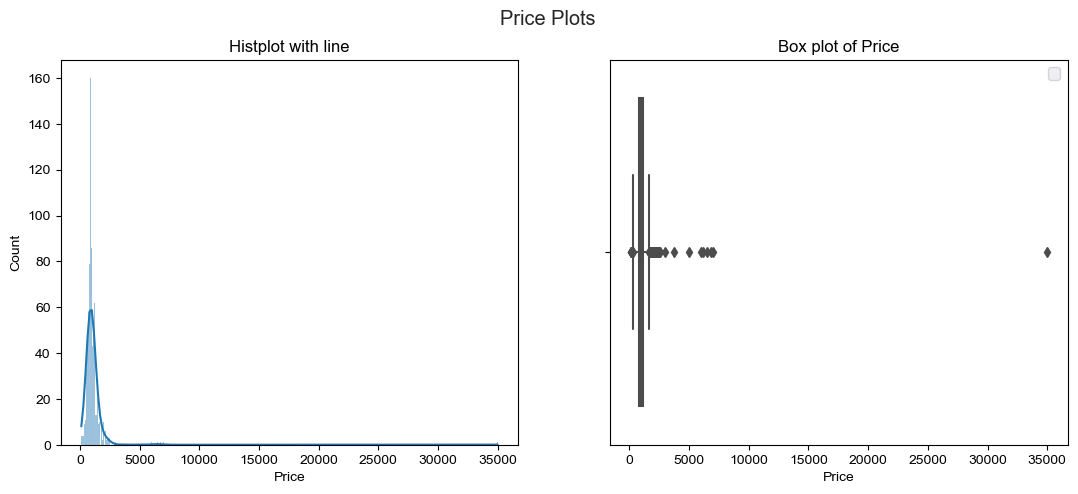

In [32]:
fig, axes = plt.subplots(1, 2, sharex=True, figsize=(13,5))
sns.set_theme()
fig.suptitle('Price Plots')
sns.histplot(ax=axes[0], data=df, x=df['Price'], kde=True)
axes[0].set_title('Histplot with line')
sns.boxplot(ax=axes[1], data=df, x=df['Price'])
axes[1].set_title('Box plot of Price')
plt.legend()
plt.show()

As we can see from the graph, the data distribution is not normal and the outliers can be clearly seen from the data distribution.
In order to have a "bell curve", we remove the clear outliers.

The descriptive statistics also indicate abnormality, the standard deviation is 1000, which is abnormal for an iPhone price.
Based on the Apple Store, Normal new IPhone prices are around 1000-1200 for the iPhone 14 Max Pro

In [33]:
# remove if title contains "case"
df = df[~df['Title'].str.contains(r'\b(case)\b', case=False, regex=True)]

# remove if df contains for parts
df = df[~df['Title'].str.contains(r'\b(parts)\b', case=False, regex=True)]

# remove if df contains repair
df = df[~df['Title'].str.contains(r'\b(repair)\b', case=False, regex=True)]

C:\Users\azhar\AppData\Local\Temp\ipykernel_16868\2759614669.py:2: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df = df[~df['Title'].str.contains(r'\b(case)\b', case=False, regex=True)]
C:\Users\azhar\AppData\Local\Temp\ipykernel_16868\2759614669.py:5: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df = df[~df['Title'].str.contains(r'\b(parts)\b', case=False, regex=True)]
C:\Users\azhar\AppData\Local\Temp\ipykernel_16868\2759614669.py:8: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df = df[~df['Title'].str.contains(r'\b(repair)\b', case=False, regex=True)]


In [34]:
df_overpriced = df[df['Price'] > 2000]

In [35]:
df_overpriced

,Title,Price,Storage Capacity,Color,Condition,color_number,Condition_number,Network Carrier,Carrier Category
51,apple iphone 15 pro max 1tb falcon 150grams 18k gold with diamonds video,35000.00,1024,Gold,Unknown,1,0,other/unknown,2
221,apple iphone 15 pro max 512gb chaos edition,7000.00,512,None,Unknown,0,0,other/unknown,2
281,apple iphone 14 pro max 512gb sealed deep purple unlocked fast next day delivery,2365.49,512,Deep purple,Unknown,3,0,unlocked,0
292,apple iphone 14 pro max 256gb deeppurple 5gunlockeddualsimfreenewsealeduk,2488.78,256,Purple,New,3,3,other/unknown,2
320,apple iphone 15 pro 512gb platinum vision edition carbon,6000.00,512,None,Unknown,0,0,other/unknown,2
336,brand new apple iphone 14 pro max 1 tb silver gsm cdma factory unlocked esim,2299.00,1024,Silver,New,2,3,unlocked,0
361,apple iphone 14 pro max apple ios smartphone in black with 1 tb storage,2525.11,1024,Black,Unknown,4,0,other/unknown,2
366,apple iphone 15 pro max 512gb bentley edition,6500.00,512,None,Unknown,0,0,other/unknown,2
370,apple iphone 15 pro max 512gb dg edition,6800.00,512,None,Unknown,0,0,other/unknown,2
386,apple iphone 15 pro 512gb sr edition with lab diamonds 24k gold,6200.00,512,Gold,Unknown,1,0,other/unknown,2


In [36]:
# Remove iPhone prices under 200 and over 2000$

df = df.drop(df.loc[(df['Price'] < 200) | (df['Price'] > 2000)].index)

In [37]:
df.shape

(871, 9)

In [38]:
df.columns

Index(['Title', 'Price', 'Storage Capacity', 'Color', 'Condition',
       'color_number', 'Condition_number', 'Network Carrier',
       'Carrier Category'],
      dtype='object')

In [39]:
df

,Title,Price,Storage Capacity,Color,Condition,color_number,Condition_number,Network Carrier,Carrier Category
0,apple iphone 14 pro max 512gb unlocked att tmobile verizon very good condition,884.95,512,None,Very good,0,3,unlocked,0
3,apple iphone 14 pro max 256gb unlocked us e sim excellent,909.99,256,None,Excellent,0,3,unlocked,0
4,apple iphone 14 pro max 128gb deep purple unlocked smartphone,810.00,128,Deep purple,Unknown,3,0,unlocked,0
5,new listingapple iphone 14 pro max 128gb black unlocked,710.00,128,Black,New,4,3,unlocked,0
6,apple iphone 14 pro max 256gb unlocked us e sim very good,889.99,256,None,Very good,0,3,unlocked,0
...,...,...,...,...,...,...,...,...,...
1018,apple iphone 14 pro max 256gb space black unlocked a2651 gsm,940.00,256,Space black,Unknown,4,0,unlocked,0
1019,apple iphone 14 pro max 128gb gold verizon,950.00,128,Gold,Unknown,1,0,verizon,1
1020,iphone 14 pro max 128gb silver unlocked,1008.98,128,Silver,Unknown,2,0,unlocked,0
1021,apple iphone 14 pro max 1tb deep purple tmobile,1300.00,1024,Deep purple,Unknown,3,0,tmobile,1


C:\Users\azhar\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


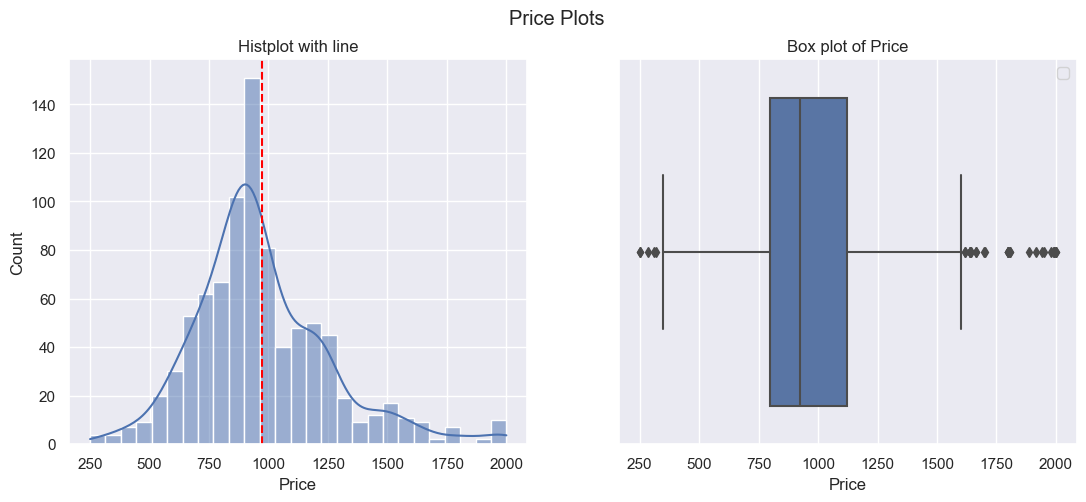

In [40]:
fig, axes = plt.subplots(1, 2, sharex=True, figsize=(13,5))
sns.set_theme()
fig.suptitle('Price Plots')
sns.histplot(ax=axes[0], data=df, x=df['Price'], kde=True)
axes[0].axvline(df['Price'].mean(), color='red', linestyle='--', label='Mean')
axes[0].set_title('Histplot with line')
sns.boxplot(ax=axes[1], data=df, x=df['Price'])
axes[1].set_title('Box plot of Price')
plt.legend()
plt.show()

In [41]:
df.describe()

,Price,Storage Capacity,color_number,Condition_number,Carrier Category
count,871.000000,871.000000,871.000000,871.000000,871.000000
mean,971.438427,328.303100,2.574053,1.006889,0.644087
std,286.036940,283.376132,1.342914,1.378805,0.756327
min,250.000000,128.000000,0.000000,0.000000,0.000000
25%,800.000000,128.000000,1.000000,0.000000,0.000000
50%,925.000000,256.000000,3.000000,0.000000,0.000000
75%,1121.070000,512.000000,4.000000,3.000000,1.000000
max,2000.000000,1024.000000,4.000000,3.000000,2.000000


In [42]:
## Remove price outliers
## TODO: Improve outlier algorithm
# remove if Z-Score more than 3 for upper-bound, and -1.5 for lower bound

# add zscore column
df['zscore'] = (df.Price - df.Price.mean())/df.Price.std()



In [43]:
# drop columns with zscore > 3 and < -2.5
df = df.drop(df.loc[(df.zscore > 2.5) | (df.zscore < -2)].index)

C:\Users\azhar\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


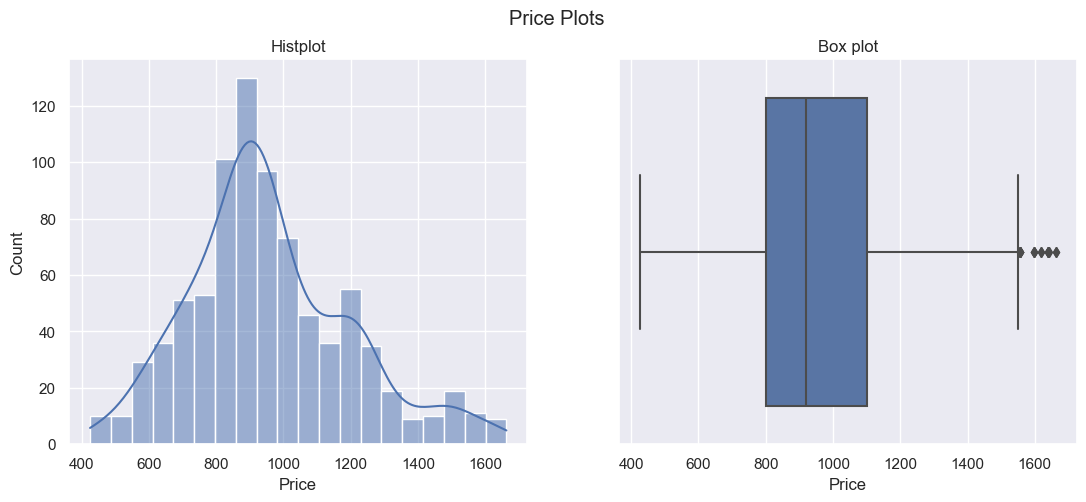

In [44]:
fig, axes = plt.subplots(1, 2, sharex=True, figsize=(13,5))
sns.set_theme()
fig.suptitle('Price Plots')
sns.histplot(ax=axes[0], data=df, x=df['Price'], kde=True)
axes[0].set_title('Histplot')
sns.boxplot(ax=axes[1], data=df, x=df['Price'])
axes[1].set_title('Box plot')


plt.show()

In [45]:
df.tail()

,Title,Price,Storage Capacity,Color,Condition,color_number,Condition_number,Network Carrier,Carrier Category,zscore
1018,apple iphone 14 pro max 256gb space black unlocked a2651 gsm,940.00,256,Space black,Unknown,4,0,unlocked,0,-0.109910
1019,apple iphone 14 pro max 128gb gold verizon,950.00,128,Gold,Unknown,1,0,verizon,1,-0.074950
1020,iphone 14 pro max 128gb silver unlocked,1008.98,128,Silver,Unknown,2,0,unlocked,0,0.131247
1021,apple iphone 14 pro max 1tb deep purple tmobile,1300.00,1024,Deep purple,Unknown,3,0,tmobile,1,1.148668
1022,apple iphone 14 pro max 128gb deep purple unlocked,980.00,128,Deep purple,Unknown,3,0,unlocked,0,0.029932


In [46]:
df = df.reset_index().drop(columns=['index', 'zscore'])

In [47]:
df.shape

(839, 9)

In [48]:
df.describe()

,Price,Storage Capacity,color_number,Condition_number,Carrier Category
count,839.000000,839.000000,839.000000,839.000000,839.000000
mean,956.867032,324.195471,2.587604,1.015495,0.644815
std,240.933825,279.051821,1.337593,1.383848,0.753793
min,425.000000,128.000000,0.000000,0.000000,0.000000
25%,800.000000,128.000000,1.000000,0.000000,0.000000
50%,919.990000,256.000000,3.000000,0.000000,0.000000
75%,1100.000000,512.000000,4.000000,3.000000,1.000000
max,1662.940000,1024.000000,4.000000,3.000000,2.000000


In [49]:
# Ready DF FINALLY!!!!
df

,Title,Price,Storage Capacity,Color,Condition,color_number,Condition_number,Network Carrier,Carrier Category
0,apple iphone 14 pro max 512gb unlocked att tmobile verizon very good condition,884.95,512,None,Very good,0,3,unlocked,0
1,apple iphone 14 pro max 256gb unlocked us e sim excellent,909.99,256,None,Excellent,0,3,unlocked,0
2,apple iphone 14 pro max 128gb deep purple unlocked smartphone,810.00,128,Deep purple,Unknown,3,0,unlocked,0
3,new listingapple iphone 14 pro max 128gb black unlocked,710.00,128,Black,New,4,3,unlocked,0
4,apple iphone 14 pro max 256gb unlocked us e sim very good,889.99,256,None,Very good,0,3,unlocked,0
...,...,...,...,...,...,...,...,...,...
834,apple iphone 14 pro max 256gb space black unlocked a2651 gsm,940.00,256,Space black,Unknown,4,0,unlocked,0
835,apple iphone 14 pro max 128gb gold verizon,950.00,128,Gold,Unknown,1,0,verizon,1
836,iphone 14 pro max 128gb silver unlocked,1008.98,128,Silver,Unknown,2,0,unlocked,0
837,apple iphone 14 pro max 1tb deep purple tmobile,1300.00,1024,Deep purple,Unknown,3,0,tmobile,1


In [50]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 839 entries, 0 to 838
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Title             839 non-null    object 
 1   Price             839 non-null    float64
 2   Storage Capacity  839 non-null    int64  
 3   Color             752 non-null    object 
 4   Condition         839 non-null    object 
 5   color_number      839 non-null    int64  
 6   Condition_number  839 non-null    int64  
 7   Network Carrier   839 non-null    object 
 8   Carrier Category  839 non-null    int64  
dtypes: float64(1), int64(4), object(4)
memory usage: 59.1+ KB


# 4    Exploratory Data Analysis

In [51]:
df.to_csv('eda_ready.csv')

In [52]:
# for exploratory data analysis, we change the column value to string.
df_eda = df.copy()

In [53]:
df_eda.describe()

,Price,Storage Capacity,color_number,Condition_number,Carrier Category
count,839.000000,839.000000,839.000000,839.000000,839.000000
mean,956.867032,324.195471,2.587604,1.015495,0.644815
std,240.933825,279.051821,1.337593,1.383848,0.753793
min,425.000000,128.000000,0.000000,0.000000,0.000000
25%,800.000000,128.000000,1.000000,0.000000,0.000000
50%,919.990000,256.000000,3.000000,0.000000,0.000000
75%,1100.000000,512.000000,4.000000,3.000000,1.000000
max,1662.940000,1024.000000,4.000000,3.000000,2.000000


In [54]:
# correlation matrix of numerical / categorical data
correlation_matrix = df_eda[['Price', 'Storage Capacity', 'color_number', 'Condition_number', 'Carrier Category']].corr()

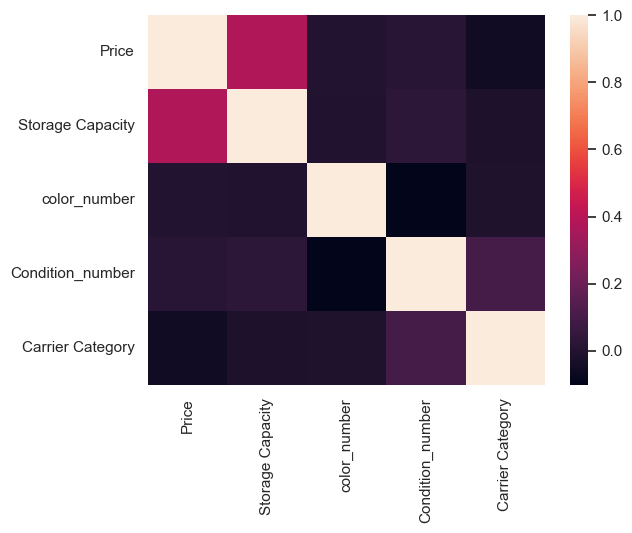

In [55]:
sns.heatmap(correlation_matrix)
plt.show()

In [56]:
data_storage_price = df_eda.groupby('Storage Capacity')['Price'].mean().reset_index()

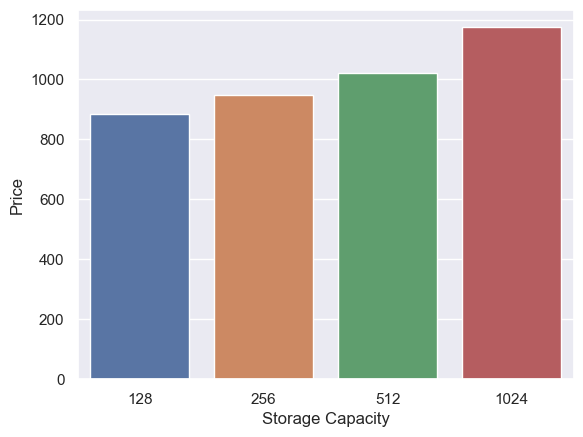

In [57]:
# Plot of Storage Capacity and Price

sns.barplot(x=data_storage_price['Storage Capacity'], y=data_storage_price['Price'])
plt.show()

In [58]:
df_eda.groupby("color_number")['Price'].mean()

color_number
0     914.258966
1    1014.298372
2     945.535176
3     939.426929
4     965.179806
Name: Price, dtype: float64

In [59]:
df_eda.groupby('Condition_number')['Price'].mean()

Condition_number
0    961.365009
1    616.074706
2    940.414231
3    971.483218
Name: Price, dtype: float64

In [60]:
df_eda.groupby('Carrier Category')['Price'].mean()

Carrier Category
0    1001.714568
1     835.792335
2    1037.030986
Name: Price, dtype: float64

In [61]:
df_eda.head(20)

,Title,Price,Storage Capacity,Color,Condition,color_number,Condition_number,Network Carrier,Carrier Category
0,apple iphone 14 pro max 512gb unlocked att tmobile verizon very good condition,884.95,512,None,Very good,0,3,unlocked,0
1,apple iphone 14 pro max 256gb unlocked us e sim excellent,909.99,256,None,Excellent,0,3,unlocked,0
2,apple iphone 14 pro max 128gb deep purple unlocked smartphone,810.00,128,Deep purple,Unknown,3,0,unlocked,0
3,new listingapple iphone 14 pro max 128gb black unlocked,710.00,128,Black,New,4,3,unlocked,0
4,apple iphone 14 pro max 256gb unlocked us e sim very good,889.99,256,None,Very good,0,3,unlocked,0
5,apple iphone 14 pro max 256gb space black unlocked fair condition,799.99,256,Space black,Fair,4,2,unlocked,0
6,new listingapple iphone 14 pro max 256gb space black carrier locked check esn,530.00,256,Space black,New,4,3,other/unknown,2
7,new listingapple iphone 14 pro max 128gb gold tmobile,660.00,128,Gold,New,1,3,tmobile,1
8,apple iphone 14 pro max 128gb space black unlocked fair condition,769.99,128,Space black,Fair,4,2,unlocked,0
9,apple iphone 14 pro max 128gb space black verizon check esn read,549.00,128,Space black,Unknown,4,0,verizon,1


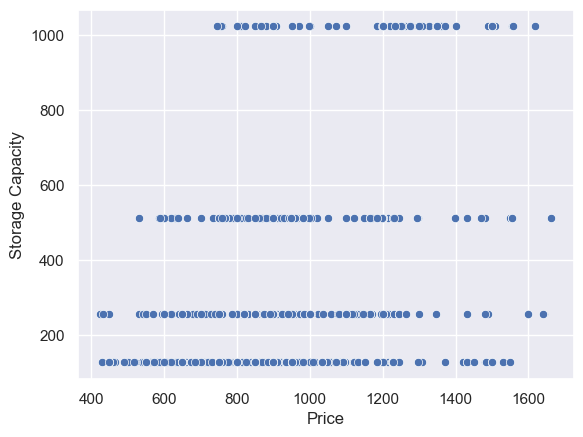

In [62]:
sns.scatterplot(data=df_eda, x='Price', y='Storage Capacity')
plt.show()

In [63]:
df_eda.head()

,Title,Price,Storage Capacity,Color,Condition,color_number,Condition_number,Network Carrier,Carrier Category
0,apple iphone 14 pro max 512gb unlocked att tmobile verizon very good condition,884.95,512,None,Very good,0,3,unlocked,0
1,apple iphone 14 pro max 256gb unlocked us e sim excellent,909.99,256,None,Excellent,0,3,unlocked,0
2,apple iphone 14 pro max 128gb deep purple unlocked smartphone,810.00,128,Deep purple,Unknown,3,0,unlocked,0
3,new listingapple iphone 14 pro max 128gb black unlocked,710.00,128,Black,New,4,3,unlocked,0
4,apple iphone 14 pro max 256gb unlocked us e sim very good,889.99,256,None,Very good,0,3,unlocked,0


## Machine Learning Model to Predict the Price

In [64]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

### Copying df and selecting features

In [65]:
df_ML = df.copy()

In [66]:
df_ML.head()

,Title,Price,Storage Capacity,Color,Condition,color_number,Condition_number,Network Carrier,Carrier Category
0,apple iphone 14 pro max 512gb unlocked att tmobile verizon very good condition,884.95,512,None,Very good,0,3,unlocked,0
1,apple iphone 14 pro max 256gb unlocked us e sim excellent,909.99,256,None,Excellent,0,3,unlocked,0
2,apple iphone 14 pro max 128gb deep purple unlocked smartphone,810.00,128,Deep purple,Unknown,3,0,unlocked,0
3,new listingapple iphone 14 pro max 128gb black unlocked,710.00,128,Black,New,4,3,unlocked,0
4,apple iphone 14 pro max 256gb unlocked us e sim very good,889.99,256,None,Very good,0,3,unlocked,0


In [67]:
# Make a ML dataframe copy, and define the features for predicting the label ('Price')
df_ML = df_ML[['Title', 'Price', 'Storage Capacity', 'color_number', 'Condition_number', 'Carrier Category']]
features = ['Storage Capacity', 'color_number', 'Condition_number', 'Carrier Category']

### Make a ColumnTransformer (scikit) using pipeline, specify the regressor on the pipeline. Split data into training and testing data

In [68]:
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(), ['Carrier Category', 'Storage Capacity', 'color_number', 'Condition_number'])
    ])

In [69]:
X = df[features]
y = df['Price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [70]:
model = Pipeline(steps=[('preprocessor', preprocessor),
                        ('regressor', LinearRegression())])

#### Fit the model

In [71]:
model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat', OneHotEncoder(),
                                                  ['Carrier Category',
                                                   'Storage Capacity',
                                                   'color_number',
                                                   'Condition_number'])])),
                ('regressor', LinearRegression())])

In [72]:
y_pred = model.predict(X_test)

In [89]:
# Put result in dataframe

df_result = pd.DataFrame(columns=['y_test', 'y_pred'])
df_result['y_test'], df_result['y_pred'] = y_test, y_pred
df_result['MSE'] = (df_result['y_test'] - df_result['y_pred'])**2

In [90]:
df_result

,y_test,y_pred,MSE
211,1662.94,1005.863793,431749.141161
825,1146.00,936.692991,43809.424107
78,790.00,1010.620412,48673.366130
67,639.99,756.555235,13587.453916
792,1228.97,999.138504,52822.516507
...,...,...,...
572,689.00,782.120615,8671.448941
774,750.00,808.237391,3391.593658
695,820.00,781.195590,1505.782233
781,1133.53,1053.024387,6481.153778


In [91]:
# Calculate the metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

# Print the results
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R-squared (R2): {r2}")

Mean Absolute Error (MAE): 164.0118543302057
Mean Squared Error (MSE): 48687.226800981174
Root Mean Squared Error (RMSE): 220.6518225643767
R-squared (R2): 0.23903127956090786


In [92]:
# Perform K-fold cross validation

k = 10  # number of folds
scores = cross_val_score(model, X, y, cv=k, scoring='neg_mean_squared_error')

# Output the average of the k-fold cross-validation scores
print(f"Average Mean Squared Error across {k} folds: {-scores.mean()}")

Average Mean Squared Error across 10 folds: 50386.15744869256


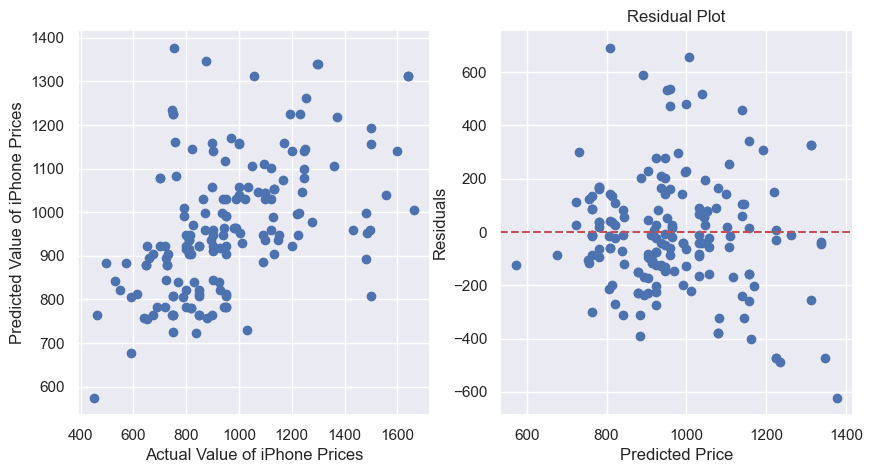

In [93]:
# plot the actual value as x axis, predicted value on y-axis
fig, ax = plt.subplots(1, 2, figsize=(10,5))

# first graph
ax[0].scatter(df_result['y_test'], df_result['y_pred'])
ax[0].set_xlabel('Actual Value of iPhone Prices')
ax[0].set_ylabel('Predicted Value of iPhone Prices')


# residuals

residuals = y_test - y_pred
ax[1].scatter(y_pred, residuals)
ax[1].set_xlabel('Predicted Price')
ax[1].set_ylabel('Residuals')
ax[1].set_title('Residual Plot')
ax[1].axhline(y=0, color='r', linestyle='--')
plt.show()


## Try RandomForest

In [94]:
model = Pipeline(steps=[('preprocessor', preprocessor),
                           ('regressor', RandomForestRegressor(random_state=42))])

In [95]:
model.fit(X_train, y_train)



Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat', OneHotEncoder(),
                                                  ['Carrier Category',
                                                   'Storage Capacity',
                                                   'color_number',
                                                   'Condition_number'])])),
                ('regressor', RandomForestRegressor(random_state=42))])

In [96]:
y_pred = model.predict(X_test)

In [97]:
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

Mean Squared Error: 48687.226800981174


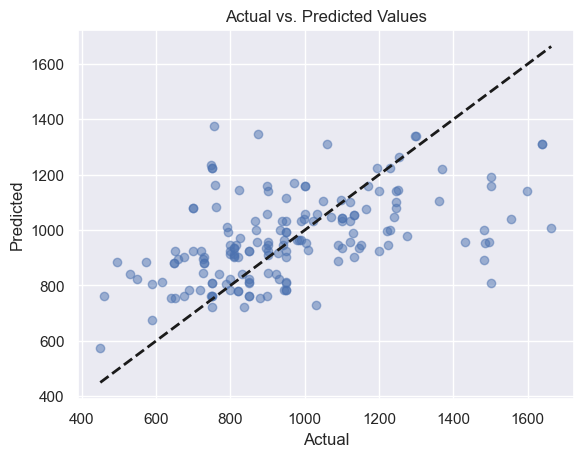

In [98]:
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs. Predicted Values')
plt.show()

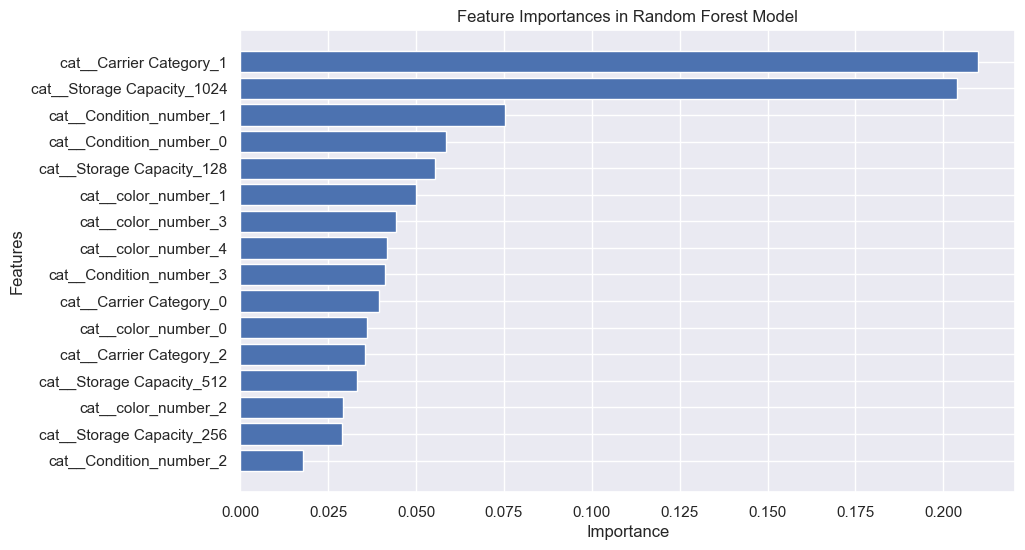

In [99]:
# Get the list of one-hot encoded column names
ohe_columns = model[:-1].get_feature_names_out()

# Combine with numerical features
all_features = list(ohe_columns)  # Replace 'numerical_features' and 'categorical_features' with your actual lists of features

# Get the feature importances
feature_importances = model.named_steps['regressor'].feature_importances_

# Create a DataFrame for feature importances
importances_df = pd.DataFrame({'Features': all_features, 'Importance': feature_importances})

# Now plot the importances as before
importances_df = importances_df.sort_values(by='Importance', ascending=False)
plt.figure(figsize=(10, 6))
plt.barh(importances_df['Features'], importances_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Feature Importances in Random Forest Model')
plt.gca().invert_yaxis()
plt.show()

In [100]:
# Calculate the metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

# Print the results
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R-squared (R2): {r2}")

Mean Absolute Error (MAE): 164.0118543302057
Mean Squared Error (MSE): 48687.226800981174
Root Mean Squared Error (RMSE): 220.6518225643767
R-squared (R2): 0.23903127956090786


Interpreting the results:
1. The mean absolute error of 164 indicates

In [101]:
# Performing K-fold cross-validation
k = 5
cv_scores = cross_val_score(model, X, y, cv=5, scoring='neg_mean_squared_error')

# Convert scores to positive and take the square root (since MSE is negative in scikit-learn)
rmse_scores = np.sqrt(-cv_scores)

print(f"RMSE scores for each fold: {rmse_scores}")
print(f"Average RMSE: {np.mean(rmse_scores)}")
print(f"Standard Deviation of RMSE: {np.std(rmse_scores)}")

RMSE scores for each fold: [247.84166396 225.0086947  241.20817962 185.86227948 288.71236852]
Average RMSE: 237.72663725477932
Standard Deviation of RMSE: 33.363565053580075


In [88]:
# Predict and Evaluate on Training Set
train_pred = model.predict(X_train)
train_rmse = np.sqrt(mean_squared_error(y_train, train_pred))

# Predict and evaluate on test set
test_pred = model.predict(X_test)
test_rmse = np.sqrt(mean_squared_error(y_test, test_pred))

print(f"Training RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")

Training RMSE: 180.44544797483127
Test RMSE: 220.6518225643767


Lower RMSE on Training set. Could this indicate overfitting? The difference is not that significant.

## Key Takeaways
1. Storage Capacity affects the prices, the higher the capacity, the more expensive the price of iPhone is.